## Importing necessary libraries

In [1]:
import numpy as np
import os
import sys

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plot_experiment import plot_episode_data_virtual, plot_one_episode, plot_trajectories_GoToXY, plot_single_xy_pose
import matplotlib.cm as cm



## Loading RL episodes

In [2]:
load_dir = "../ros_lab_exp/7_9_23/nominal_UF_0.25_GoToPose_MLP_expRew_PE_0.03/"
experiments = os.listdir(load_dir)
# remove the .png files or .csv files
experiments = [experiment for experiment in experiments if ".png" not in experiment and ".csv" not in experiment]
print(experiments)

# getting all the actions for all the episodes under the @load_dir experiments witouth the first column

all_RL_actions = [pd.read_csv(load_dir + experiment + "/" + ep + "/actions.csv", index_col=None)
                        for experiment in experiments for ep in os.listdir(load_dir + experiment) if ".png" not in ep and ".npy" not in ep]
all_RL_obs = [pd.read_csv(load_dir + experiment + "/" + ep + "/states_episode.csv", index_col=None) 
                        for experiment in experiments for ep in os.listdir(load_dir + experiment) if ".png" not in ep and ".npy" not in ep]
# remove form df the first columns
all_RL_actions = [df.iloc[:, 1:] for df in all_RL_actions]
all_RL_obs = [df.iloc[:, 1:] for df in all_RL_obs]


['20230907-161722', '20230907-165814', '20230908-161541']


In [3]:
all_RL_obs[1]

,cos_theta,sin_theta,lin_vel_x,lin_vel_y,ang_vel_z,task_flag,error_x,error_y,cos_error_heading,sin_error_heading
0,-0.726989,0.686399,0.000053,-0.000011,-0.001459,1.0,-2.093630,-1.082429,-0.727165,-0.686463
1,-0.727012,0.686374,-0.000007,0.000025,0.000519,1.0,-2.093619,-1.082444,-0.727389,-0.686225
2,-0.725654,0.687804,0.000348,-0.003475,-0.014176,1.0,-2.093683,-1.081820,-0.725399,-0.688329
3,-0.700830,0.713171,0.004394,-0.043825,-0.220440,1.0,-2.094521,-1.074192,-0.696845,-0.717221
4,-0.636899,0.770576,0.007378,-0.082599,-0.446282,1.0,-2.095881,-1.059118,-0.634793,-0.772683
...,...,...,...,...,...,...,...,...,...,...
193,0.998520,0.053781,-0.015361,-0.001367,-0.192065,1.0,-0.001419,0.007957,0.998696,-0.051052
194,0.999913,0.009924,-0.018579,-0.003305,-0.221277,1.0,0.002140,0.008637,0.999970,-0.007743
195,0.999897,-0.013964,-0.003469,0.000059,-0.083918,1.0,0.003248,0.008940,0.999905,0.013762
196,0.999838,0.015650,0.016290,-0.000475,0.185707,1.0,0.000404,0.009140,0.999820,-0.018951


In [4]:
# convert all_RL_obs[1] to numpy array
all_RL_obs = [df.to_numpy() for df in all_RL_obs]

In [5]:
len(all_RL_obs), len(all_RL_obs[0])

(3, 198)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

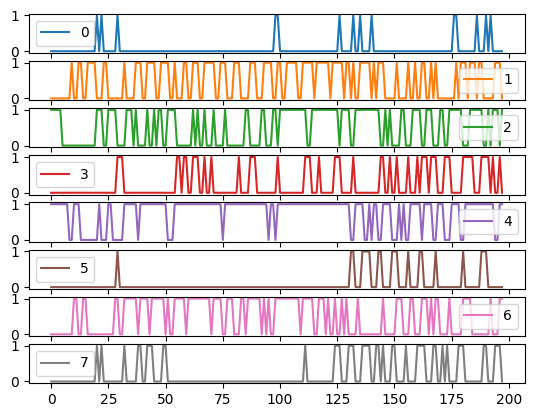

In [6]:
all_RL_actions[0].plot(subplots=True)

In [7]:
all_RL_actions[0]

,0,1,2,3,4,5,6,7
0,0,0,1,0,1,0,0,0
1,0,0,1,0,1,0,0,0
2,0,0,1,0,1,0,0,0
3,0,0,1,0,1,0,0,0
4,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
193,0,0,1,1,1,0,0,0
194,0,1,1,0,0,0,0,1
195,0,1,1,0,0,0,0,1
196,0,1,0,1,1,0,1,1


In [8]:
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection


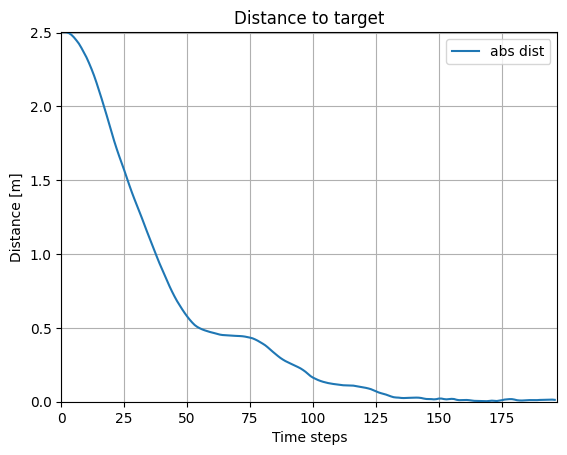

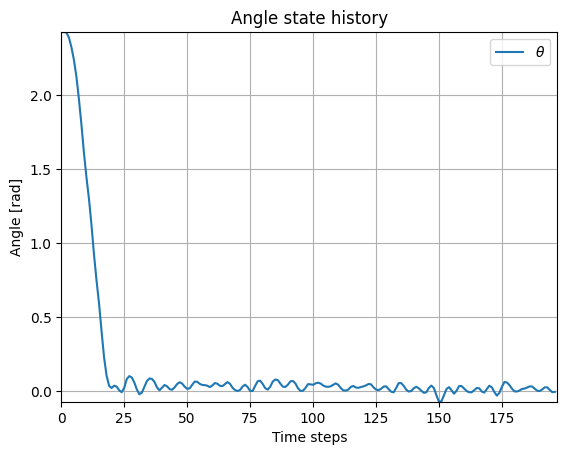

In [48]:

def update_distance(frame, tgrid, pos_error, line):
    line.set_data(tgrid[:frame], np.linalg.norm(np.array([pos_error[:frame, 0], pos_error[:frame, 1]]), axis=0))
    return line,

def update_heading(frame, tgrid, angles, line):
    line.set_data(tgrid[:frame], angles[:frame])
    return line,

def plot_distance_and_heading_videos(state_history: np.ndarray, tgrid: np.ndarray, save_dir: str, fps: int = 10, show: bool = True):
    """
    Plot distance and heading of a single agent and save them as videos using Matplotlib.
    """
    pos_error = state_history[:, 6:8]
    headings = state_history[:, :2]
    angles = np.arctan2(headings[:, 1], headings[:, 0])

    # Create a directory to save the video frames
    os.makedirs(save_dir, exist_ok=True)

    # Set up the figures and axes
    fig_distance, ax_distance = plt.subplots()
    line_distance, = ax_distance.plot([], [], color=cm.get_cmap('tab20')(0))
    ax_distance.set_xlim(0, np.max(tgrid))
    ax_distance.set_ylim(0, np.max(np.linalg.norm(pos_error, axis=1)))
    ax_distance.set_xlabel('Time steps')
    ax_distance.set_ylabel('Distance [m]')
    ax_distance.legend(['abs dist'], loc='best')
    ax_distance.set_title('Distance to target')
    ax_distance.grid()

    fig_heading, ax_heading = plt.subplots()
    line_heading, = ax_heading.plot([], [], color=cm.get_cmap('tab20')(0))
    ax_heading.set_xlim(0, np.max(tgrid))
    ax_heading.set_ylim(np.min(angles), np.max(angles))
    ax_heading.set_xlabel('Time steps')
    ax_heading.set_ylabel('Angle [rad]')
    ax_heading.legend(['${\\theta}$'], loc='best')
    ax_heading.set_title('Angle state history')
    ax_heading.grid()

    # Function to update the plots for each frame
    def update(frame):
        update_distance(frame, tgrid, pos_error, line_distance)
        update_heading(frame, tgrid, angles, line_heading)
        return line_distance, line_heading

    # Create animations for both plots
    ani_distance = FuncAnimation(fig_distance, update, frames=len(tgrid), blit=True)
    ani_heading = FuncAnimation(fig_heading, update, frames=len(tgrid), blit=True)

    # Save the animations as MP4 videos
    distance_video_filename = os.path.join(save_dir, 'distance_to_target_video.mp4')
    heading_video_filename = os.path.join(save_dir, 'angle_state_history_video.mp4')
    ani_distance.save(distance_video_filename, writer='ffmpeg', fps=fps)
    ani_heading.save(heading_video_filename, writer='ffmpeg', fps=fps)

    if show:
        plt.show()

# Example usage
state_history = np.random.rand(100, 8)  # Replace with actual state history data
tgrid = np.arange(len(all_RL_obs[0]))  # Replace with actual time grid data
save_dir = 'path_to_save_directory'  # Replace with the desired save directory
fps = 10  # Frames per second for the videos

plot_distance_and_heading_videos(all_RL_obs[0], tgrid, save_dir, fps)


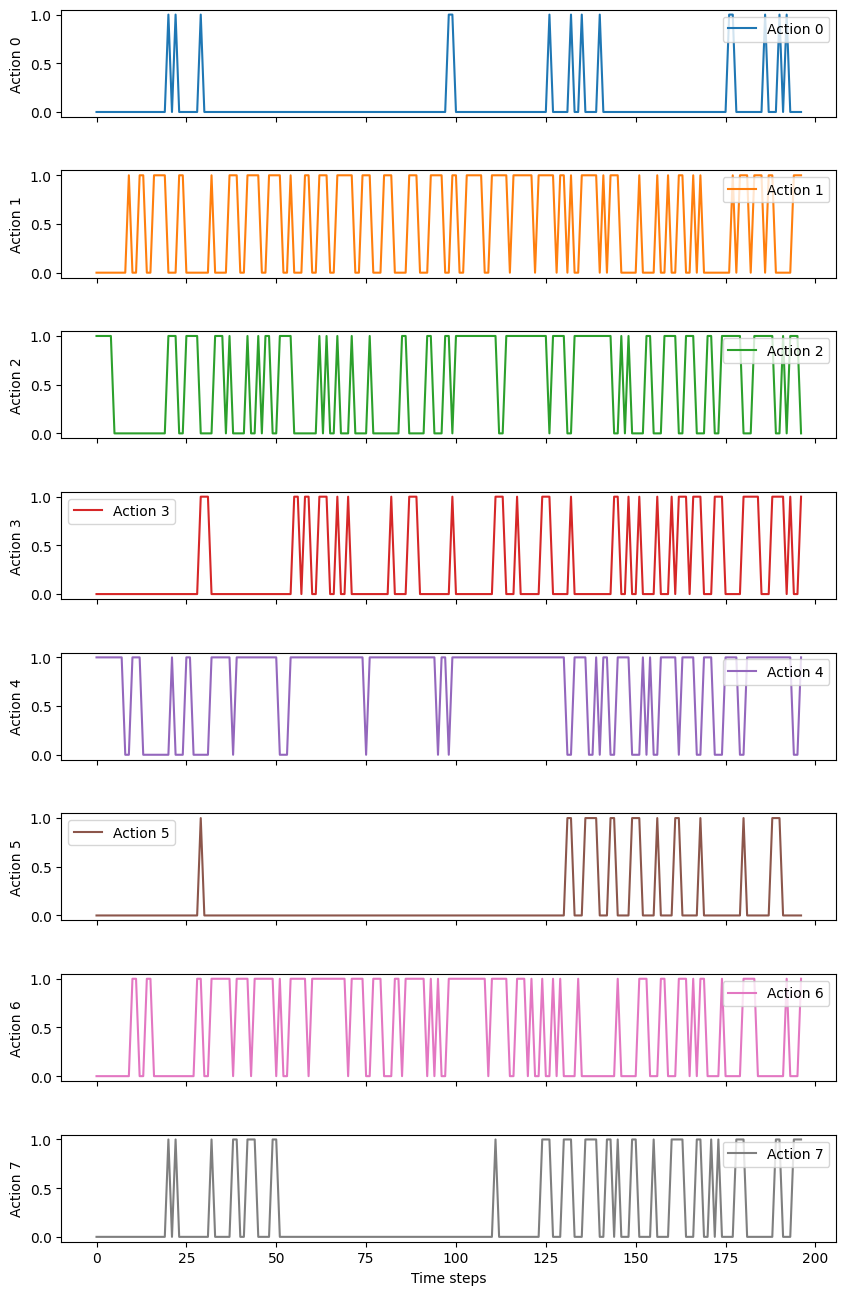

In [72]:

def plot_binarized_actions(df: pd.DataFrame, save_dir: str, fps: int = 10):
    """
    Plot binarized actions sequentially and save as a video using Matplotlib.
    """
    # Create a directory to save the video frames
    os.makedirs(save_dir, exist_ok=True)

    # Set up the figure and axes
    num_actions = len(df.columns)
    fig, axes = plt.subplots(num_actions, 1, figsize=(10, num_actions * 2), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.5)
    plt.xlabel('Time steps')

    colors = plt.cm.tab10.colors  # Set of distinct colors

    lines = []
    for i in range(num_actions):
        line, = axes[i].plot([], [], color=colors[i], label=f'Action {i}')
        axes[i].set_ylabel(f'Action {i}')
        axes[i].legend(loc='best')
        lines.append(line)


    # Function to update the plot for each frame
    def update(frame):
        for i in range(num_actions):
            lines[i].set_data(df.index[:frame], df[df.columns[i]][:frame])
            axes[i].relim()
            axes[i].autoscale_view()
        plt.xlabel('Time steps')
        return lines

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(df), blit=True)

    # Save the animation as an MP4 video
    video_filename = os.path.join(save_dir, 'binarized_actions_video.mp4')
    ani.save(video_filename, writer='ffmpeg', fps=fps)

    plt.show()

# Example usage
# Assuming all_RL_actions[0] is the DataFrame containing binarized actions
# Replace with your actual DataFrame
#all_RL_actions = [pd.DataFrame(np.random.randint(2, size=(100, 8)), columns=range(8))]

# Replace 'path_to_save_directory' with the desired save directory
save_dir = 'path_to_save_directory'

# Frames per second for the video
fps = 10

# Plot the binarized actions and save as a video
plot_binarized_actions(all_RL_actions[0], save_dir, fps)
